# Meeting July 12

In [83]:
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
import h5py

import common
from common.constants import (LARGE_ROOM_DIMS)

# Calibration Curve on fake data

Before looking into the calibration of MUSE for different smoothing methods, examine how the calibration curve function works for fake data.

Define functions `uniform_samples`, `std_normal_samples`, and `skewed_normal_samples` to take in a positive integer `N`, and return `N` draws from their respective distributions.

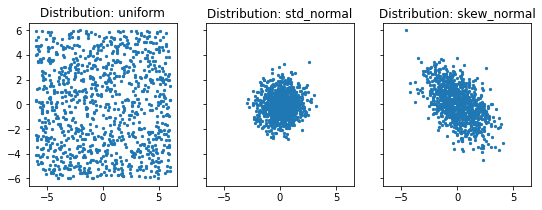

In [2]:
# generate fake data of different distributions
rng = np.random.default_rng(seed=2022)

# rescale to be on the square [-6, 6]^2 (arbitrarily chosen)
uniform_samples = lambda n_samples: (rng.uniform(size=(n_samples, 2)) * 12) - 6

std_normal_samples = lambda n_samples: rng.normal(size=(n_samples, 2))

SKEW_COV = [[2, -1], [-1, 2]]
skewed_normal_samples = lambda n_samples: rng.multivariate_normal(
    mean=[0, 0],
    cov=SKEW_COV,
    size=n_samples
)

# group each distr into one convenient function
observed_data = lambda n: {
    'uniform': uniform_samples(n),
    'std_normal': std_normal_samples(n),
    'skew_normal': skewed_normal_samples(n),
}

# for now, use a large number of samples
LARGE_N = 1000

large_n_data = observed_data(LARGE_N)

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
for ax, (distr_name, data) in zip(axs, large_n_data.items()):
    ax.scatter(data[:, 0], data[:, 1], s=5)
    ax.set_title(f'Distribution: {distr_name}')

In [3]:
# create fake model output corresponding to the above distributions

GRID_RESOLUTION = 0.1
# everything falls within square [-6, 6]^2
xgrid, ygrid = np.meshgrid(
    np.linspace(-6, 6, int(12/GRID_RESOLUTION)),
    np.linspace(-6, 6, int(12/GRID_RESOLUTION))
)

n_gridpts = xgrid.shape[0] * xgrid.shape[1]
perfect_uniform_model = np.ones(xgrid.shape) * (1 / n_gridpts)

std_normal_model = scipy.stats.multivariate_normal(
    mean=[0,0], cov=1
    ).pdf(np.dstack((xgrid, ygrid)))

skewed_normal_model = scipy.stats.multivariate_normal(
    mean=[0,0], cov=SKEW_COV
    ).pdf(np.dstack((xgrid, ygrid)))

# and renormalize
std_normal_model /= std_normal_model.sum()
skewed_normal_model /= skewed_normal_model.sum()

models = {
    'uniform': perfect_uniform_model,
    'std_normal': std_normal_model,
    'skew_normal': skewed_normal_model
}

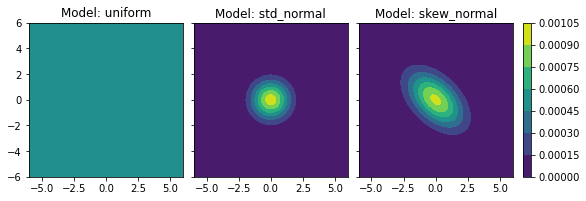

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(9, 3))
grid = ImageGrid(fig, 111, # similar to subplot(111)
                 nrows_ncols=(1, 3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_mode="single",
                 )

for ax, (distr_name, model) in zip(grid, models.items()):
    contour = ax.contourf(xgrid, ygrid, model)
    ax.set_title(f'Model: {distr_name}')

ax.cax.colorbar(contour)

plt.show()

With our models and data defined, we now examine the calibration curve results for different combinations of the above, still using a large sample size of 1000.

In [45]:
from common.calibration import plot_calibration_curve

def model_calibration(data, models, samples_to_use=None, plot=True):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
    if not plot:
        plt.close(fig)
    errs = {}
    for ax, (sample_name, samples), (model_name, model) in zip(axs, data.items(), models.items()):
        # if provided a string in data.keys(), evaluate each model
        # against those samples rather than their corresponding samples
        if samples_to_use:
            sample_name = samples_to_use
            samples = data[samples_to_use]
        n_samples = len(samples)
        
        bin_edges, true_props = plot_calibration_curve(
            model[np.newaxis, :].repeat(n_samples, axis=0),
            samples,
            xgrid,
            ygrid,
            ax
        )
        ax.set_title(f'Model: {model_name} | Samples: {sample_name}')
        
        # calculate sum of residuals versus the line y = x
        errs[model_name] = np.abs(bin_edges - true_props).sum()
    fig.tight_layout()
    plt.show()
    return errs

First, look at each model on its corresponding data. Keep track of the error for each model against each set of data in `errs_overall`, where we define the error to be the sum of the residual distances between the plot and the line $ y = x $.

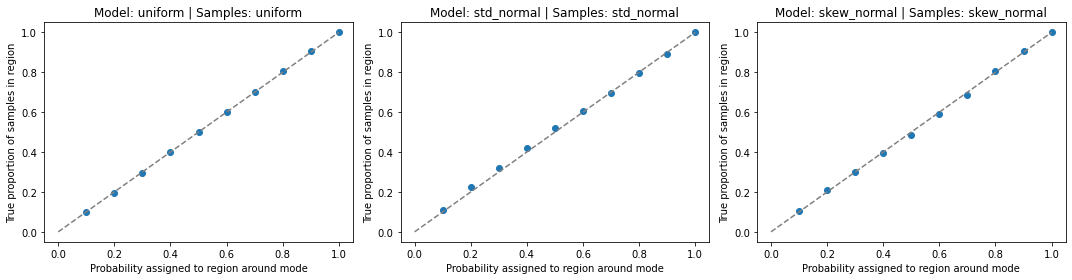

In [6]:
_ = model_calibration(large_n_data, models)

Great! Looks like the models are well-calibrated, as expected. Now, everything versus uniform.

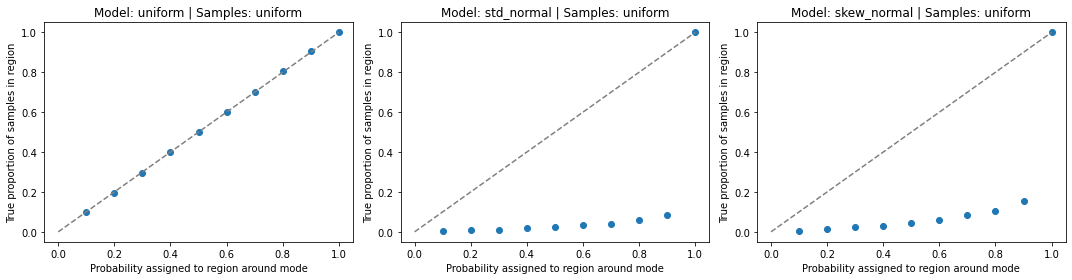

In [7]:
errs_overall = {}
errs_overall['uniform'] = model_calibration(large_n_data, models, samples_to_use='uniform')

Here, we see that the models predicting a Gaussian distribution on the space fall far under the expected $y = x$ line. This means that the true proportion of samples inside a region tends to be much lower than the probability the model assigns the region, which makes sense considering that the models are very overconfident.

Next, everything versus spherical Gaussian.

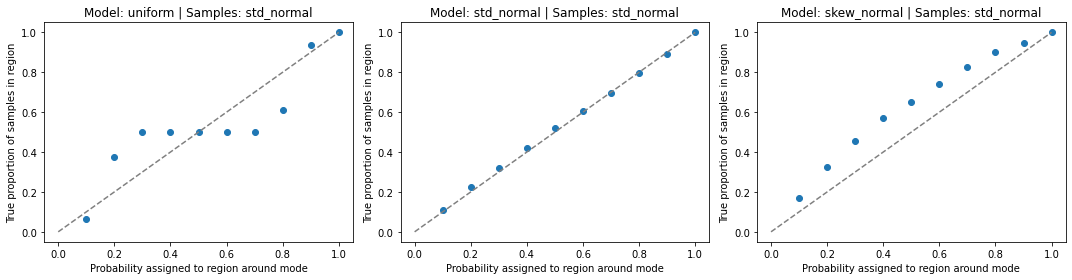

In [8]:
errs_overall['std_normal'] = model_calibration(large_n_data, models, samples_to_use='std_normal')

Finally, everything versus the skewed Gaussian.

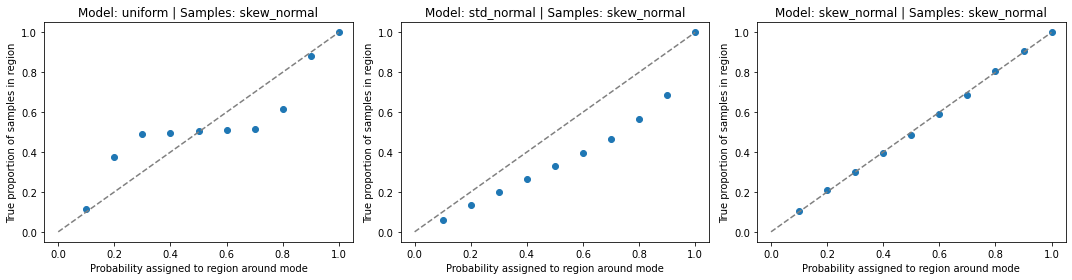

In [9]:
errs_overall['skew_normal'] = model_calibration(large_n_data, models, samples_to_use='skew_normal')

Now look into the errors.

In [10]:
def visualize_calibration_err(overall_err: dict):
    """
    Plot a grouped bar chart visualizing calibration error for
    the models and samples.
    """
    # note: assume err dict has the following structure.
    # overall_err
    #    |- data sample 1
    #         |- model 1
    #         |- model 2
    #         |- ...
    #    |- data sample 2
    #         |- ...
    #    |- ...
    
    # the label locations
    x = np.arange(len(overall_err.keys()))
    # the width of the bars
    width = 0.3

    fig, ax = plt.subplots(figsize=(7,7))

    # flip the dict to be broken down by model then by sample
    model_names = list(overall_err.values())[0].keys()
    model_errs_by_sample = {model_name: {} for model_name in model_names}

    for sample_name, errs in overall_err.items():
        for model_name, err in errs.items():
            model_errs_by_sample[model_name][sample_name] = err

    # helper function to calculate bar placement
    offset = lambda idx: (idx - int(len(x) / 2)) * width

    # plot grouped bar chart: grouped by data sample, colored by model
    for i, (model_name, errs) in enumerate(model_errs_by_sample.items()):
        ax.bar(x + offset(i), errs.values(), width, label=f'model: {model_name}')

    ax.set_ylabel('Error vs. perfect calibration')
    ax.set_title('Calibration curve residual errors by model and sample')
    ax.set_xticks(x, [f'data: {k}' for k in errs_overall.keys()])
    ax.legend()

    plt.show()

    return model_errs_by_sample

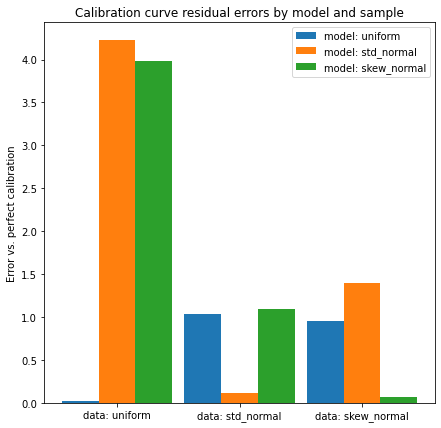

In [11]:
large_n_errs_by_sample = visualize_calibration_err(errs_overall)

### Fewer samples
Since we can be reasonably confident that the calibration curve function works, let's now take a look at smaller sample sizes.

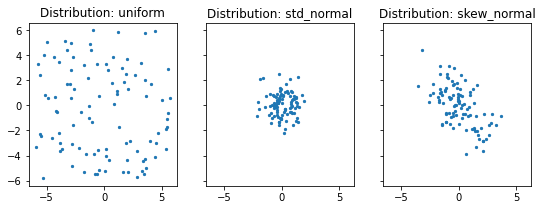

In [12]:
SMALLER_N = 100
smaller_n_data = observed_data(SMALLER_N)

# display data

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
for ax, (distr_name, data) in zip(axs, smaller_n_data.items()):
    ax.scatter(data[:, 0], data[:, 1], s=5)
    ax.set_title(f'Distribution: {distr_name}')

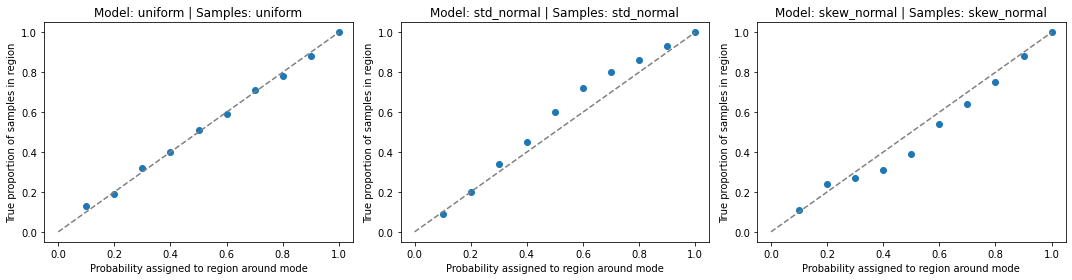

In [13]:
# examine calibration
_ = model_calibration(smaller_n_data, models)

Seems empirically a little bit noisier than before. Let's take a look at all the combinations.

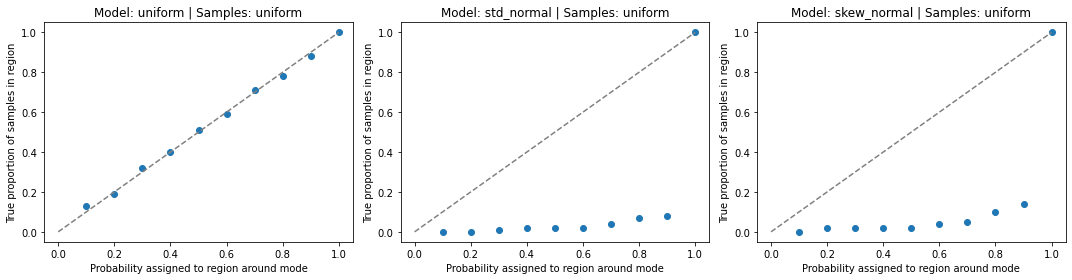

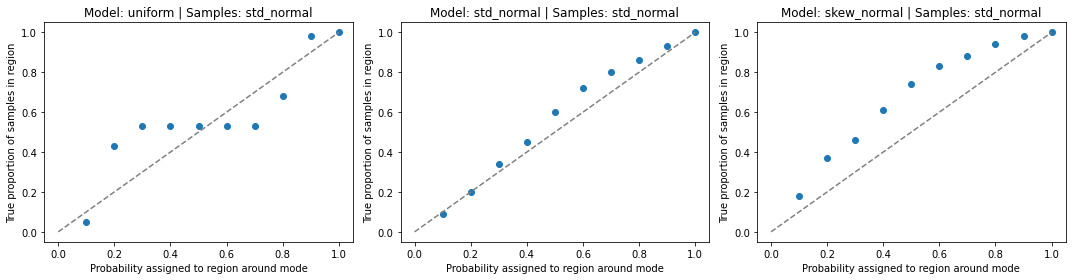

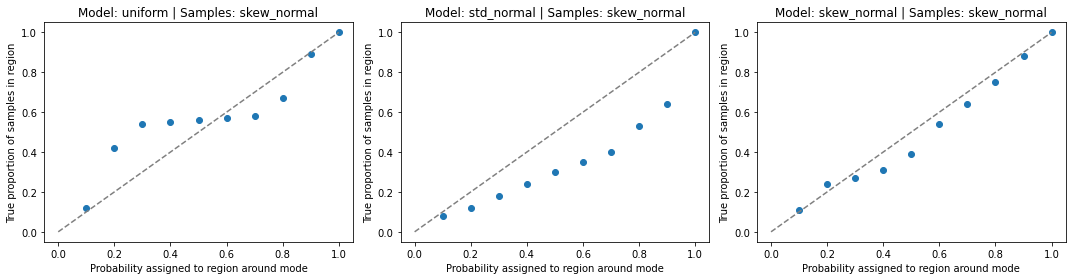

In [14]:
smaller_n_errs = {}

for sample_name in smaller_n_data.keys():
    smaller_n_errs[sample_name] = model_calibration(smaller_n_data, models, samples_to_use=sample_name)

Still seems reasonable! Take a look at the residual calibration error.

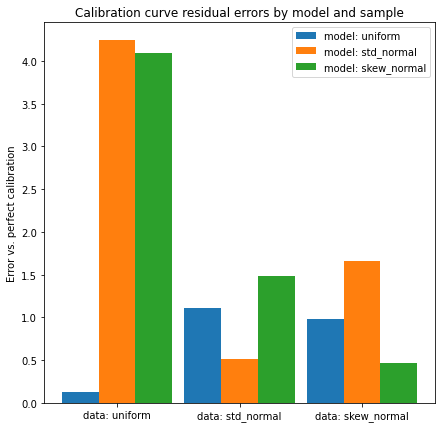

In [15]:
small_n_errs_by_sample = visualize_calibration_err(smaller_n_errs)

Looks like the errors are still relatively high for mismatching distributions and they're easily distinguishable. It does seem like errors have increased for matching distributions, though.

In [16]:
for (model_name, small_n_errs), large_n_errs in zip(small_n_errs_by_sample.items(), large_n_errs_by_sample.values()):
    print(
        f"""
Model: {model_name} | Sample: {model_name}
--------
N = {LARGE_N} error: {large_n_errs[model_name]:.4f}
N = {SMALLER_N} error: {small_n_errs[model_name]:.4f}
        """
    )


Model: uniform | Sample: uniform
--------
N = 1000 error: 0.0260
N = 100 error: 0.1300
        

Model: std_normal | Sample: std_normal
--------
N = 1000 error: 0.1160
N = 100 error: 0.5100
        

Model: skew_normal | Sample: skew_normal
--------
N = 1000 error: 0.0740
N = 100 error: 0.4700
        


Looks like that's definitely the case. Now let's try various other `n` values and plot the errors.

In [33]:
observed_data(2)

{'uniform': array([[-0.96624545, -0.18161288],
        [-2.58873207,  2.74106377]]),
 'std_normal': array([[ 0.00446638,  0.17617673],
        [-0.48508964, -0.83870748]]),
 'skew_normal': array([[-1.27885299, -0.55469374],
        [-0.79668621,  1.33993753]])}

In [80]:
def test_n_values(n_iterator, sample_fn, models, samples_to_use=None, plot=True):
    errs = {m: [] for m in models.keys()}
    for n in n_iterator:
        samples = sample_fn(n)
        err_results = model_calibration(samples, models, samples_to_use=samples_to_use, plot=False)
        for name, err in err_results.items():
            errs[name].append(err)
    if plot:
        fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
        for ax, (model, err_line) in zip(axs, errs.items()):
            ax.scatter(n_iterator, err_line)
            ax.set_xlabel('number of samples')
            ax.set_ylabel('error')
            sample_used = samples_to_use if samples_to_use else model
            ax.set_title(f'model: {model} | sample: {sample_used}')
        fig.suptitle('Effect of varying N on calibration error')
        plt.subplots_adjust(top=0.8)
        plt.show()
    return errs

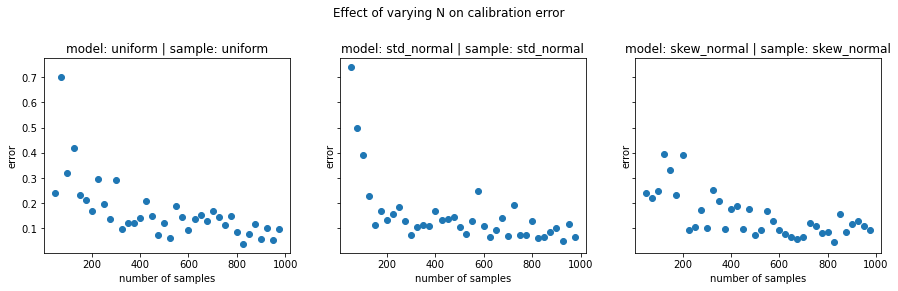

In [81]:
n_range = range(50, 1000, 25)

errs = test_n_values(n_range, observed_data, models)

Looks like past around 200 or so, the exact number of samples isn't terribly important for well-calibrated models. We do seem to get noisier results for smaller values of `N`, though. Let's see the effect on incorrect models.

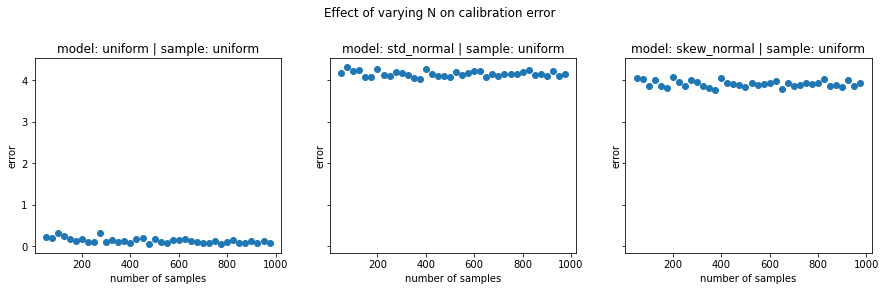

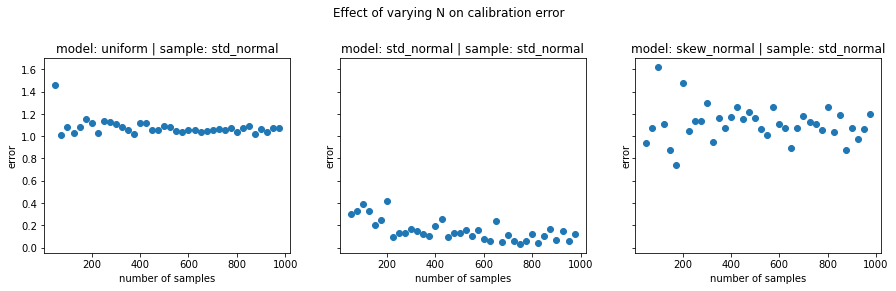

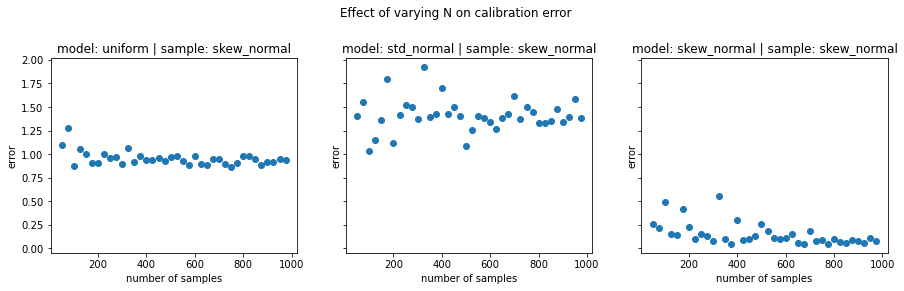

In [82]:
mismatch_distr_errs = {}
for sample_name in models.keys():
    mismatch_distr_errs[sample_name] = test_n_values(
        n_range,
        observed_data,
        models,
        samples_to_use=sample_name
    )

Seems like overall, the incorrect distributions have a much higher calibration error, regardless of the number of samples drawn. Encouraging!

## Adding noise
All of the above results are reassuring, but still in an ideal setting. Now add some spherical gaussian noise.

#### Mismatched Variances
To better understand how to interpret the calibration curves, generate spherical gaussian data of variance $\sigma$, then define a set of spherical gaussian model outputs with variances $\sigma_i \in [0.1 \sigma, \ 2 \sigma]$.

In [ ]:
from common.calibration import plot_calibration_curve

# first sample from a bunch of distributions
# and have the model output be various other distributions
rng = np.random.default_rng(seed=2022)

xgrid, ygrid = np.meshgrid(
    np.linspace(-6, 6, 120),
    np.linspace(-6, 6, 120)
)

fake_data = rng.normal(size=(1000, 2))



### Examine different smoothing methods on newly generated data
The underlying data was Aramis's `iteration/split_twelve_raw/train_set.h5` file, which contains pyroomacoustics fake data generated on a room of shape 1.83 by 2.44 by 0.76 (m).

In [13]:
# MUSE output evaluated on the above dataset (run with resolution = 0.001 m)
PREDICTIONS = Path.home() / 'ceph' / 'np_arrays' / 'split_twelve_raw' / 'train_set_muse_preds.h5'
LOCATIONS = Path('/mnt/ceph/users/atanelus/iteration/split_twelve_raw/train_set.h5')

RESOLUTION_USED = 0.001

In [7]:
locs = h5py.File(LOCATIONS, 'r')['locations']

In [8]:
locs

<HDF5 dataset "locations": shape (16000, 2), type "<f4">

In [9]:
import h5py
preds = h5py.File(PREDICTIONS, 'r')

# shape sanity check
print(preds['r_ests'])
print(preds['rsrp_grids'])

<HDF5 dataset "r_ests": shape (16000, 4, 2), type "<f8">
<HDF5 dataset "rsrp_grids": shape (16000, 1830, 2440), type "<f8">


In [14]:
xdim, ydim = LARGE_ROOM_DIMS[1:]
xs = np.linspace(0, xdim, int(xdim / RESOLUTION_USED))
ys = np.linspace(0, ydim, int(ydim / RESOLUTION_USED))

xgrid, ygrid = np.meshgrid(xs, ys)

In [16]:
class SmoothingFunctions:
    def __init__(xgrid, ygrid, r_ests_arr, rsrp_grids_arr):
        # self.r_ests = np.array(r_ests_arr)
        # self.rsrp_grids = np.array(rsrp_grids_arr)
        self.xgrid = xgrid
        self.ygrid = ygrid
    
    def simple_softmax(self, combine_method='avg'):
        """Naively apply a softmax to the RSRP grids to convert them into probability maps."""
        ## TODO swap order of avg and softmaxing

        # combine the grids from each point estimate
        if combine_method == 'avg':
            combined = self.rsrp_grids.mean(axis=1)
        elif combine_method == 'sum':
            combined = self.rsrp_grids.sum(axis=1)
        # normalize them so we don't get crazy infinity values from exponentiation step of softmax
        max_val = combined.max(axis=0)
        combined /= max_val
        # then apply softmax
        softmaxed = np.exp(combined) / np.exp(combined).sum(axis=(1, 2))
        return self.xgrid, self.ygrid, softmaxed
    
    def gaussian_at_each_jackknife(self, sigma=1, larger_bins=True):
        """
        Place a spherical gaussian of variance sigma at each jackknife estimate,
        renormalize, and return.
        """
        # decrease the resolution of the bins by a factor of 10 or so
        # to save memory
        xgrid, ygrid = self.xgrid, self.ygrid
        if larger_bins:
            xgrid = self.xgrid[::10, ::10]
            ygrid = self.ygrid[::10, ::10]
        results = np.zeros((len(r_ests_arr), xgrid.shape[0], xgrid.shape[1]))
        n_mics = self.r_ests.shape[1]
        for i, point_ests in enumerate(self.r_ests):
            # create n_mics normal distributions, each centered at one point estimate
            # and with mean sigma
            distrs = scipy.stats.norm(point_ests, [sigma] * n_mics)
            # evaluate each distribution at each point on the grid
            pmfs = distrs.pdf(np.dstack(xgrid, ygrid)[np.newaxis, :].repeat(n_mics, axis=0))
            # average the results to get one distribution
            results[i] = pmfs.mean(axis=0)
        return xgrid, ygrid, results        
            
    def convolve_gaussian(self, sigma=0.5, renormalize=True):
        """Convolve a spherical gaussian kernel of variance sigma over each map."""
        # TODO: make argument the pixel width of the filter,
        # not sigma
    
        # first renormalize just in case
        grids = self.rsrp_grids
        if renormalize:
            grids /= self.rsrp_grids.max(axis=0)
        for i, g in enumerate(grids):
            grids[i] = scipy.ndimage_gaussian_filter(g, sigma=sigma)
        # lastly, apply softmax
        grids = np.exp(grids) / np.exp(grids).sum(axis=(1, 2))
        return self.xgrid, self.ygrid, grids

    def perfect_uniform(self, larger_bins=False):
        xgrid, ygrid = self.xgrid, self.ygrid
        if larger_bins:
            xgrid = self.xgrid[::10][::10]
            ygrid = self.ygrid[::10][::10]
        
        num_pts = xgrid.shape[1] * xgrid.shape[2]
        uniform = np.ones(shape) / num_pts
        return xgrid, ygrid, uniform
    
    # def uniform_with_peak():
    #     pass

def examine_calibration(xgrid, ygrid, results):
    common.calibration.plot_calibration_curve(
        results,
        locs,
        xgrid,
        ygrid
    )

In [ ]:
small_subset_smoothing = SmoothingFunctions(
    xgrid,
    ygrid,
    preds['r_ests'][:1000],
    preds['rsrp_grids'][:1000]
)